<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recommender%20Systems/PyTorch_Recommender_20M_MODIFIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.utils import shuffle

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#     global current_user_id, custom_user_map
#     old_user_id = row['userId']
#     if old_user_id not in custom_user_map:
#         custom_user_map[old_user_id] = current_user_id
#         current_user_id += 1
#     return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [7]:
# Now do the same for movieId

# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#     global current_movie_id, custom_movie_map
#     old_movie_id = row['movieId']
#     if old_movie_id not in custom_movie_map:
#         custom_movie_map[old_movie_id] = current_movie_id
#         current_movie_id += 1
#     return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [8]:
# Get user IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [9]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [10]:
# Make the neural network
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        # set the weights since N(0, 1) leads to poor results
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
        
    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)
        
        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)
        
        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [12]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [14]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # batches per epoch
    Ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(Ntrain / bs))
    
    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []

        # shuffle each batch
        train_users, train_movies, train_ratings = shuffle(
            train_users, train_movies, train_ratings
        )

        for j in range(batches_per_epoch):
            # get the batch
            users = train_users[j*bs:(j+1)*bs]
            movies = train_movies[j*bs:(j+1)*bs]
            targets = train_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        test_loss = []
        for j in range(int(np.ceil(len(test_users) / bs))):
            # get the batch
            users = test_users[j*bs:(j+1)*bs]
            movies = test_movies[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, targets).item()
            test_loss.append(loss)
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [15]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [16]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model, 
    criterion, 
    optimizer, 
    (train_users, train_movies, train_ratings), 
    (test_users, test_movies, test_ratings), 
    10)

Epoch 1/10, Train Loss: 0.7356, Test Loss: 0.6909, Duration: 0:00:52.271245
Epoch 2/10, Train Loss: 0.6682, Test Loss: 0.6624, Duration: 0:00:50.519699
Epoch 3/10, Train Loss: 0.6356, Test Loss: 0.6509, Duration: 0:00:50.149967
Epoch 4/10, Train Loss: 0.6142, Test Loss: 0.6428, Duration: 0:00:49.886218
Epoch 5/10, Train Loss: 0.5969, Test Loss: 0.6417, Duration: 0:00:49.303522
Epoch 6/10, Train Loss: 0.5839, Test Loss: 0.6343, Duration: 0:00:49.721797
Epoch 7/10, Train Loss: 0.5741, Test Loss: 0.6331, Duration: 0:00:49.137345
Epoch 8/10, Train Loss: 0.5667, Test Loss: 0.6271, Duration: 0:00:49.155352
Epoch 9/10, Train Loss: 0.5608, Test Loss: 0.6249, Duration: 0:00:49.480570
Epoch 10/10, Train Loss: 0.5559, Test Loss: 0.6261, Duration: 0:00:49.209432


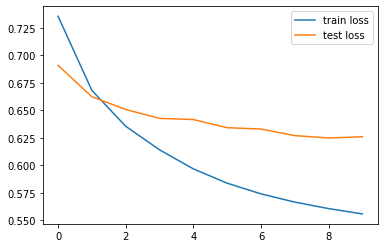

In [17]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()